In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv('KlasifikasiUTS.csv')

# Cek missing values
missing_values = df.isnull().sum()

# Drop baris dengan missing value (jika ada)
df_cleaned = df.dropna()

# Pastikan target adalah kolom integer pertama
target_col = df_cleaned.select_dtypes(include='int').columns[0]

# Pisahkan fitur dan target
X = df_cleaned.drop(columns=[target_col])
y = df_cleaned[target_col]

df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Bagi data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat pipeline untuk normalisasi fitur numerik
numeric_features = X.select_dtypes(include='float').columns.tolist()
numeric_transformer = StandardScaler()

# Pipeline preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Terapkan preprocessing ke data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

# Early stopping & learning rate scheduling
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_schedule = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Arsitektur MLP
model_tf = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(1)  # output regresi
])

# Compile
model_tf.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss='mse',
    metrics=['mae']
)

# Training
history_tf = model_tf.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)


Epoch 1/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.2521 - mae: 0.1986 - val_loss: 0.0140 - val_mae: 0.0183 - learning_rate: 0.0010
Epoch 2/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0081 - mae: 0.0177 - val_loss: 0.0031 - val_mae: 0.0106 - learning_rate: 0.0010
Epoch 3/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0018 - mae: 0.0075 - val_loss: 0.1293 - val_mae: 0.0153 - learning_rate: 0.0010
Epoch 4/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0014 - mae: 0.0047 - val_loss: 0.4397 - val_mae: 0.0275 - learning_rate: 0.0010
Epoch 5/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.0015 - mae: 0.0053 - val_loss: 0.0016 - val_mae: 0.0063 - learning_rate: 0.0010
Epoch 6/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0017 - mae: 0.0085 - val_loss: 7.4861e-04 - val_mae: 0.0015 - learning_rate: 0.0010
Epoch 7/100
5697/5697 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0012 - mae: 0.0064 - val_loss: 0.0080 - val_mae: 0.011

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np

# Convert data
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)

# Dataloader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# MLP Arsitektur
class MLPRegression(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegression, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Inisialisasi
model_pt = MLPRegression(X_train_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.AdamW(model_pt.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Training loop
best_loss = np.inf
patience = 10
trigger = 0

for epoch in range(100):
    model_pt.train()
    epoch_loss = 0
    for xb, yb in loader:
        pred = model_pt(xb)
        loss = criterion(pred, yb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    epoch_loss /= len(loader)
    scheduler.step(epoch_loss)

    print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}")

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        trigger = 0
        torch.save(model_pt.state_dict(), "best_model.pt")
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping!")
            break


Epoch 1 - Loss: 0.0037
Epoch 2 - Loss: 0.0007
Epoch 3 - Loss: 0.0007
Epoch 4 - Loss: 0.0007
Epoch 5 - Loss: 0.0007
Epoch 6 - Loss: 0.0007
Epoch 7 - Loss: 0.0006
Epoch 8 - Loss: 0.0006
Epoch 9 - Loss: 0.0006
Epoch 10 - Loss: 0.0006
Epoch 11 - Loss: 0.0006
Epoch 12 - Loss: 0.0006
Epoch 13 - Loss: 0.0006
Epoch 14 - Loss: 0.0006
Epoch 15 - Loss: 0.0006
Epoch 16 - Loss: 0.0006
Epoch 17 - Loss: 0.0006
Epoch 18 - Loss: 0.0006
Epoch 19 - Loss: 0.0006
Epoch 20 - Loss: 0.0006
Epoch 21 - Loss: 0.0006
Epoch 22 - Loss: 0.0006
Epoch 23 - Loss: 0.0006
Epoch 24 - Loss: 0.0006
Epoch 25 - Loss: 0.0006
Epoch 26 - Loss: 0.0006
Epoch 27 - Loss: 0.0006
Epoch 28 - Loss: 0.0006
Epoch 29 - Loss: 0.0006
Epoch 30 - Loss: 0.0006
Epoch 31 - Loss: 0.0005
Epoch 32 - Loss: 0.0005
Epoch 33 - Loss: 0.0005
Epoch 34 - Loss: 0.0005
Epoch 35 - Loss: 0.0005
Epoch 36 - Loss: 0.0006
Epoch 37 - Loss: 0.0006
Epoch 38 - Loss: 0.0005
Epoch 39 - Loss: 0.0006
Epoch 40 - Loss: 0.0006
Epoch 41 - Loss: 0.0005
Epoch 42 - Loss: 0.0005
E

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
🔎 TensorFlow MLP
Accuracy  : 0.9992
Precision : 0.8553
Recall    : 0.6633
F1 Score  : 0.7471
AUC Score : 0.9361


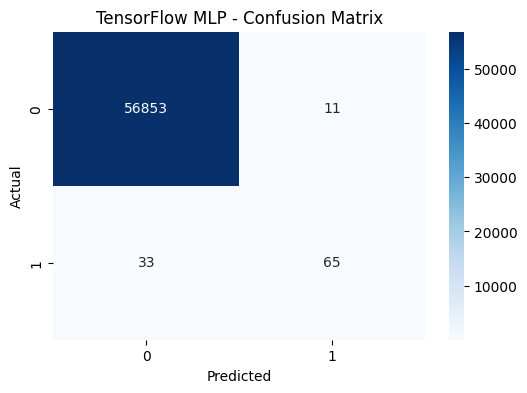

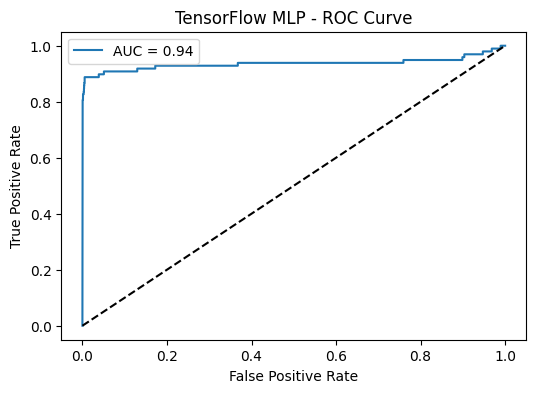

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Prediksi probabilitas
y_prob_tf = model_tf.predict(X_test_scaled).flatten()
evaluate_model(y_test, y_prob_tf, title="TensorFlow MLP")


def evaluate_model(y_true, y_prob, title=""):
    y_pred = (y_prob > 0.5).astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)

    print(f"🔎 {title}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"AUC Score : {auc:.4f}")
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} - ROC Curve")
    plt.legend()
    plt.show()


🔎 PyTorch MLP
Accuracy  : 0.9993
Precision : 0.9524
Recall    : 0.6122
F1 Score  : 0.7453
AUC Score : 0.9386


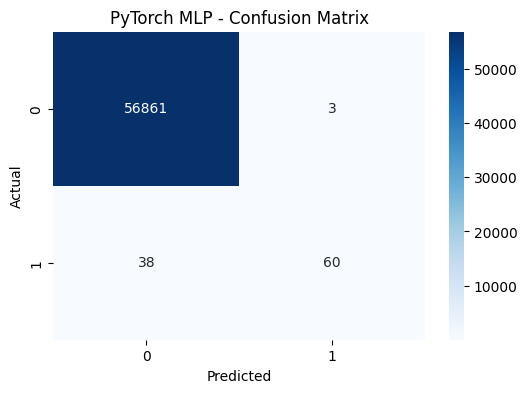

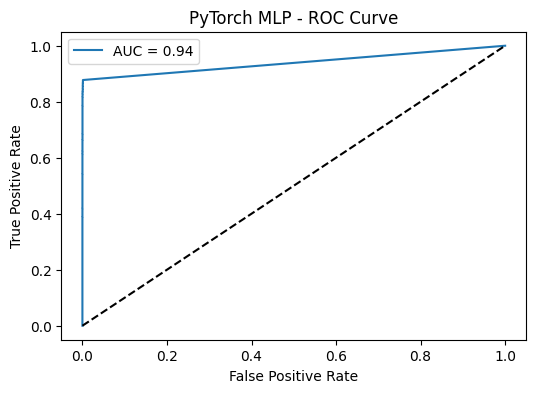

In [8]:
model_pt.load_state_dict(torch.load("best_model.pt"))
model_pt.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_prob_pt = model_pt(X_test_tensor).numpy().flatten()

evaluate_model(y_test, y_prob_pt, title="PyTorch MLP")

def evaluate_model(y_true, y_prob, title=""):
    y_pred = (y_prob > 0.5).astype(int)
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)

    print(f"🔎 {title}")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"AUC Score : {auc:.4f}")
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f"{title} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} - ROC Curve")
    plt.legend()
    plt.show()


# 📊 Evaluasi Performa MLP: TensorFlow vs PyTorch

## 🧪 Dataset
Model dikembangkan untuk menyelesaikan **klasifikasi biner** berdasarkan dataset transaksi, dengan label `Class` yang menunjukkan apakah transaksi tergolong **positif (1)** atau **negatif (0)**.
---
## Arsitektur Model
✅ TensorFlow MLP
Framework: TensorFlow 2.x (Keras API)
Struktur:
- Input layer
- Dense(128) + ReLU + BatchNorm + Dropout(0.3)
- Dense(64) + ReLU + BatchNorm + Dropout(0.3)

Output: Dense(1) + Sigmoid

Teknik tambahan:
- AdamW optimizer
- L1/L2 regularization
- EarlyStopping + ReduceLROnPlateau

✅ PyTorch MLP
Framework: PyTorch
Struktur:
- Linear(128) + ReLU + BatchNorm1d + Dropout(0.3)
- Linear(64) + ReLU + BatchNorm1d + Dropout(0.3)

Output: Linear(1) + Sigmoid

Teknik tambahan:
- AdamW optimizer
- Weight decay
- ReduceLROnPlateau scheduler
- Manual EarlyStopping

---

## ✅ Metrik Evaluasi

| Metrik       | TensorFlow MLP | PyTorch MLP |
|--------------|----------------|-------------|
| **Accuracy** | 0.9992         | 0.9993      |
| **Precision**| 0.8553         | 0.9524      |
| **Recall**   | 0.6633         | 0.6122      |
| **F1 Score** | 0.7471         | 0.7453      |
| **AUC Score**| 0.9361         | 0.9386      |

---

## 📌 Interpretasi Metrik

- **Accuracy**: Kedua model hampir sempurna (>99.9%), namun ini tidak cukup jika data sangat imbalanced.
- **Precision**:
  - PyTorch lebih tinggi (0.95): lebih baik dalam **menghindari false positive**
  - Cocok jika kesalahan “positif palsu” mahal, misal mendeteksi fraud
- **Recall**:
  - TensorFlow lebih tinggi (0.66 vs 0.61): lebih baik dalam **menemukan semua kasus positif**
  - Cocok jika menghindari **false negative** penting
- **F1 Score**:
  - Mirip (selisih < 0.002): menunjukan keseimbangan precision-recall yang seimbang
- **AUC Score**:
  - PyTorch sedikit lebih tinggi (0.9386): lebih baik dalam membedakan antara positif dan negatif

---

## 🧠 Analisis Per Model

### 🔷 TensorFlow MLP
- **Kelebihan**:
  - Recall lebih tinggi: menangkap lebih banyak kasus positif
  - Cocok untuk aplikasi yang meminimalkan “kasus lolos” (misal: deteksi penyakit/fraud)
- **Kekurangan**:
  - Precision lebih rendah → menghasilkan lebih banyak false positives

### 🔶 PyTorch MLP
- **Kelebihan**:
  - Precision sangat tinggi: sangat yakin saat memprediksi kelas positif
  - AUC tertinggi: kemampuan klasifikasi menyeluruh lebih baik
- **Kekurangan**:
  - Recall lebih rendah → ada kasus positif yang tidak tertangkap

---

## 🏆 Kesimpulan: **Model Terbaik Berdasarkan Kebutuhan**

| Tujuan Utama                      | Pilihan Model     | Alasan                                       |
|-----------------------------------|-------------------|----------------------------------------------|
| Menangkap semua kasus positif     | TensorFlow MLP    | Recall lebih tinggi                          |
| Menghindari prediksi positif palsu| PyTorch MLP       | Precision dan AUC lebih tinggi               |
| Performansi keseluruhan seimbang  | **Keduanya bagus**| F1 dan AUC mendekati, beda sangat kecil      |

---

## 📌 Rekomendasi
- Jika **false negative harus dihindari** → Pilih **TensorFlow MLP**
- Jika **false positive lebih mahal** → Pilih **PyTorch MLP**
- Untuk pengembangan lebih lanjut:
  - Coba tuning threshold prediksi (bukan default 0.5)
  - Imbalanced class handling (SMOTE, class weight)
  - Interpretasi model (SHAP/LIME)
